# Time series forecasting

## Objective

* Forecast traffic on JetRail for the next 7 months
* Unicorn Investors will only invest if there are more than 1 million monthly users within the next 18 months


## Hypothesis

* Traffic increases over the years. Population has an upward trend with time. Companies expand their business over time leading to more customers
* Traffic will be higher over May to October. Tourist visits increase during this time period
* Weekday traffic is more than weekends / holidays. People travel to work / college during the weekdays leading to higher traffic
* Traffic is higher during peak hours. This is when most people are travelling to work / college

In [1]:
# Core libraries
import pandas as pd 
from pandas import Series
import numpy as np         
from datetime import datetime   
        
# Data visualization
import matplotlib.pyplot as plt 
%matplotlib inline 

# Suppress warnings
import warnings                   
warnings.filterwarnings("ignore")

## Read data

* Data features:
  * ID. Unique number of each observation
  * Datetime. Date and time of each observation
  * Count. Passenger count at each datetime

In [2]:
train = pd.read_csv("Train_SU63ISt.csv") 
test = pd.read_csv("Test_0qrQsBZ.csv")

In [5]:
print(f"train dimensions {train.shape}")
print(f"test dimensions {test.shape}")

train dimensions (18288, 3)
test dimensions (5112, 2)


In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


## Feature extraction

* Datetime is a string. Convert to datetime format
* Extract the year, month, day and hour information from Datetime. We need this to check our date-based hypothesis
* Determine whether a date occurred on a weekend or weekday

In [6]:
# Datetime column  is of type 'object' i.e. a string
train.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [7]:
# Datetime column  is of type 'object' i.e. a string
test.dtypes

ID           int64
Datetime    object
dtype: object

In [8]:
# Convert Datetime column for both train and test sets from string to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M') 

In [9]:
for col in (train, test):
    col['year'] = col.Datetime.dt.year 
    col['month'] = col.Datetime.dt.month 
    col['day'] = col.Datetime.dt.day    
    col['Hour'] = col.Datetime.dt.hour

In [10]:
train.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [11]:
test.head()

,ID,Datetime,year,month,day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


In [12]:
# Convert Datetime to a weekday number, Saturday (5) Sunday (6)
train['Weekend'] = train['Datetime'].dt.weekday >= 5

# Output is boolean (True, False). Convert to integer (1, 0)
train['Weekend'] = train['Weekend'].astype(int)

## Plot time series

In [13]:
# X-axis is Datetime
train.set_index('Datetime')

,ID,Count,year,month,day,Hour,Weekend
Datetime,,,,,,,
2012-08-25 00:00:00,0,8,2012,8,25,0,1
2012-08-25 01:00:00,1,2,2012,8,25,1,1
2012-08-25 02:00:00,2,6,2012,8,25,2,1
2012-08-25 03:00:00,3,2,2012,8,25,3,1
2012-08-25 04:00:00,4,2,2012,8,25,4,1
...,...,...,...,...,...,...,...
2014-09-25 19:00:00,18283,868,2014,9,25,19,0
2014-09-25 20:00:00,18284,732,2014,9,25,20,0
2014-09-25 21:00:00,18285,702,2014,9,25,21,0


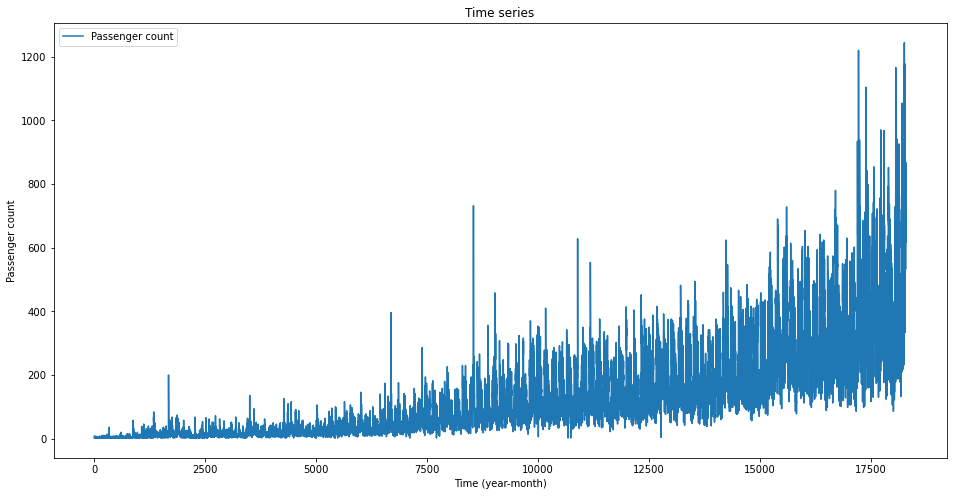

In [17]:
df = train.drop(columns = ['ID'])

# Display time series
plt.figure(figsize=(16, 8))
plt.plot(df['Count'], label="Passenger count")
plt.title("Time series")
plt.xlabel("Time (year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()